# ITChromo -> Identificação de Cromossomos utilizando "Segment Anything" (Meta)

- Repositório Modelo -> https://github.com/facebookresearch/segment-anything<br/>

- Para instalação do modelo, utilizar: "pip install git+https://github.com/facebookresearch/segment-anything.git"

In [1]:
# Conjunto de Importações
import cv2
import random
from segment_anything import sam_model_registry 
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patches as patches

In [2]:
'''
    Antes de utilizarmos o "Segment Anything" localmente, devemos baixar o seu modelo e seus datasets de treinamento.
    Para isso, baixaremos diretamente do KAGGLE, através da lib "kagglehub" e o "shutil" para movermos o arquivo para o diretório desejado
    Como podemos ver a seguir:
'''

import kagglehub            # -> lib do kaggle
import shutil
import os

# Nome do modelo e caminhos
model_name = "sam_vit_b_01ec64.pth"
model_dir = "./models/segment_anything"
final_model_path = os.path.join(model_dir, model_name)

# Se o modelo final já existe e tem tamanho plausível (>1MB), evita baixar de novo
if os.path.exists(final_model_path) and os.path.getsize(final_model_path) > 1_000_000:
    print(f"✅ Modelo já existe em: {final_model_path}")
else:
    print("⬇️  Tentando baixar modelo vit_b do Segment Anything...")

    # FORÇA o re-download limpando o cache se necessário
    kagglehub_cache = os.path.expanduser("~/.cache/kagglehub")
    if os.path.exists(kagglehub_cache):
        print("🧹 Limpando cache do kagglehub...")
        shutil.rmtree(kagglehub_cache)

    # Tenta baixar novamente
    try:
        model_path = kagglehub.model_download('metaresearch/segment-anything/PyTorch/vit-b/1')
    except Exception as e:
        print(f"❌ Erro ao baixar o modelo: {e}")
        exit(1)

    # Cria diretório final, se necessário
    os.makedirs(model_dir, exist_ok=True)

    # Move e renomeia o arquivo baixado
    moved = False
    for file_name in os.listdir(model_path):
        if file_name.endswith(".pth"):
            src = os.path.join(model_path, file_name)
            dst = os.path.join(model_dir, model_name)
            shutil.copy(src, dst)
            print(f"✅ Modelo salvo como: {dst}")
            moved = True

    if not moved:
        print("❌ Nenhum arquivo .pth encontrado após o download.")


✅ Modelo já existe em: ./models/segment_anything\sam_vit_b_01ec64.pth


In [3]:
# Função Auxiliar para plottagem e visualização das máscaras de cada cromossomo
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0],m.shape[1],3))
        color_mask = np.random.random((1,3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.8)))

In [4]:
# sam_checkpoint = '/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth'
sam_checkpoint = os.path.join("./models/segment_anything", "sam_vit_b_01ec64.pth")
model_type = "vit_b"            # tipo do modelo -> vision transformer
device = "cpu"                  # cpu ou cuda

# Inicializa o modelo com o checkpoint correto
# Inicialização do modelo utilizando o checkpoinnt
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Criação do gerador de máscaras
mask_generator1 = SamAutomaticMaskGenerator(sam)

# GERAÇÃO AUTOMÁTICA DE MÁSCARA

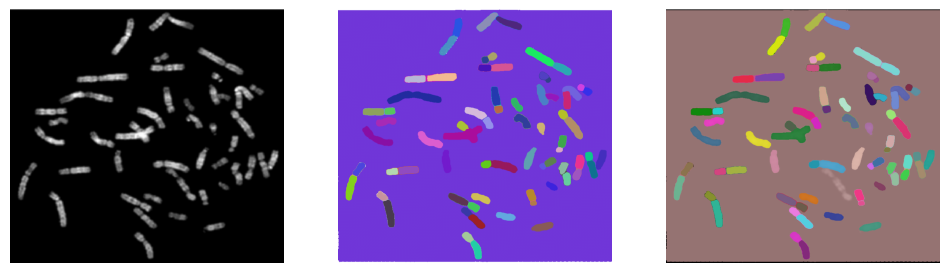

In [5]:
# path0='/kaggle/input/chromosome-image-dataset-karyotype/Data/24_chromosomes_object/JEPG/103064.jpg'
path0='..\datasets\ITChromo\ITChromo-FundoPreto.png'                                    # TESTE INICIAL COM IMAGEM de FUNDO PRETO
image = cv2.imread(path0)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.resize(image0,dsize=None,fx=0.1,fy=0.1)

masks1 = mask_generator1.generate(image)

fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(image)
axs[2].imshow(image) 
show_anns(masks1,axs[1])
show_anns(masks1,axs[2])
axs[0].axis('off')
axs[1].axis('off')    
axs[2].axis('off')    
plt.show()

In [6]:
# Criação de uma máscara totalmente branca, que será usada como FUNDO NEUTRO para criação de novas máscaras
bgw=np.ones(image.shape)*255
print(len(masks1))                      # quantas máscaras foram detectadas (cada máscara é um dicionário)
print(masks1[0].keys())                 # acessa o dicionário da primeira máscara

89
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


(847, 913, 3)


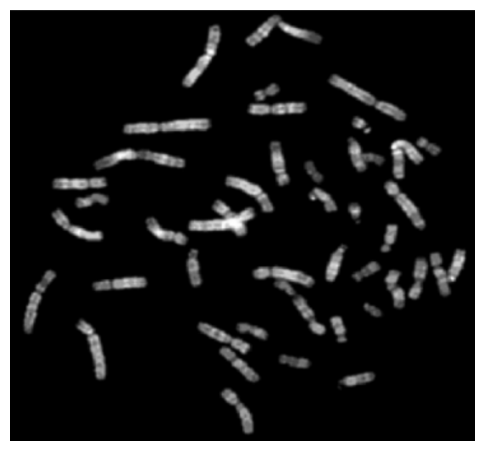

In [7]:
print(image.shape)
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off') 
plt.show()

## Cortes de máscara da imagem

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


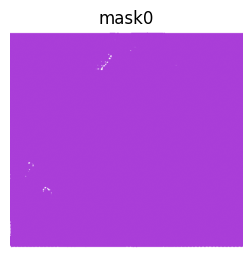

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


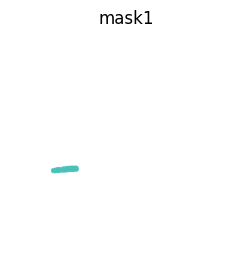

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


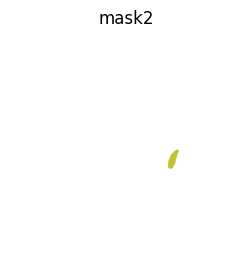

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


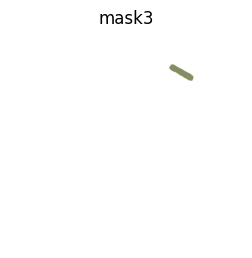

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


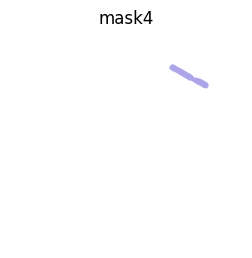

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


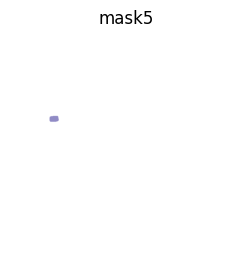

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


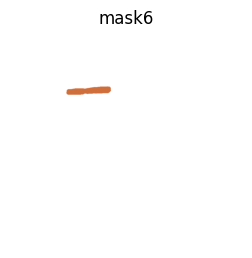

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


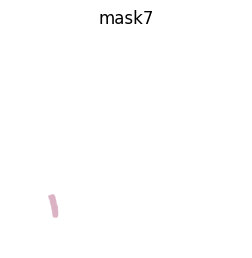

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


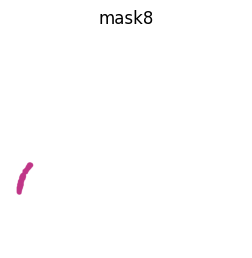

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


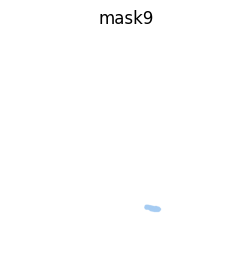

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


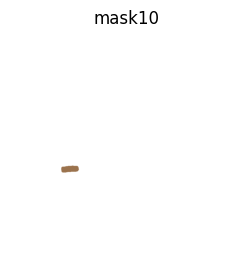

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


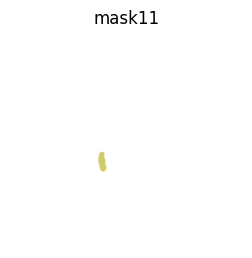

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


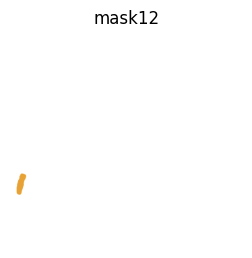

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


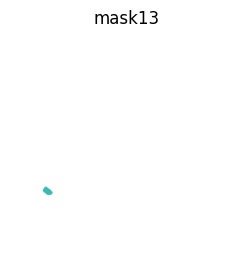

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


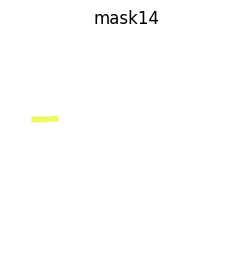

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


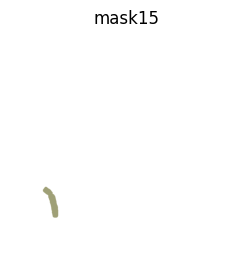

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


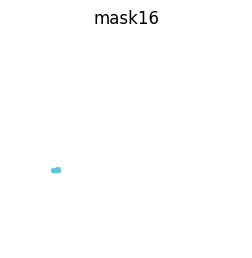

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


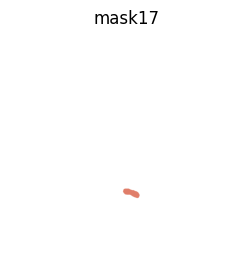

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


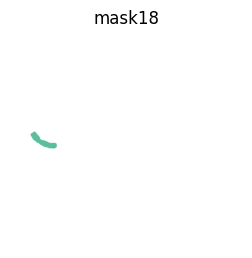

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


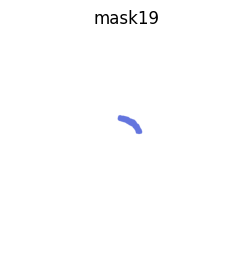

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


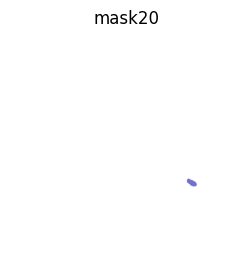

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


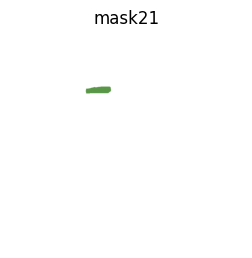

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


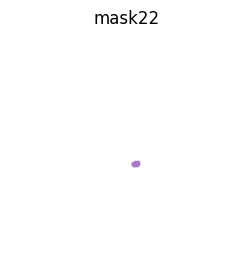

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


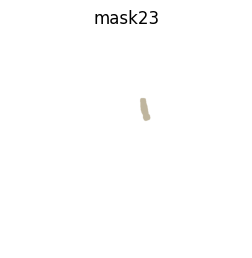

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


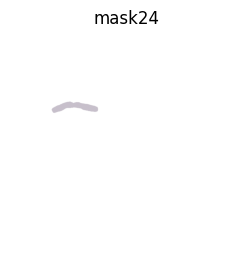

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


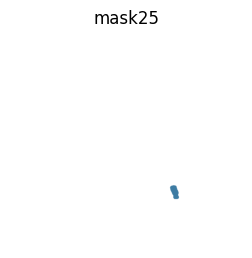

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


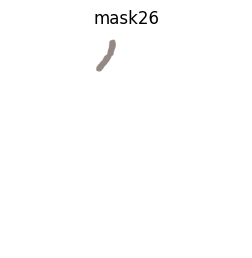

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


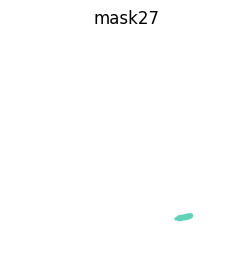

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


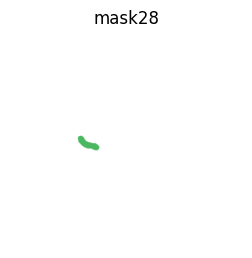

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


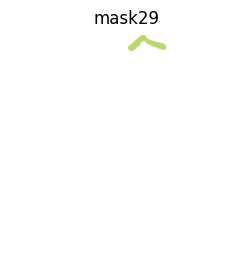

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


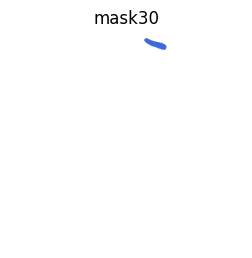

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


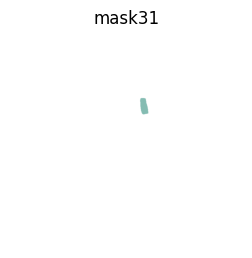

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


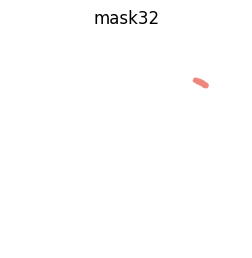

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


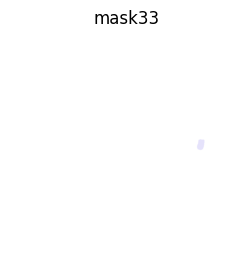

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


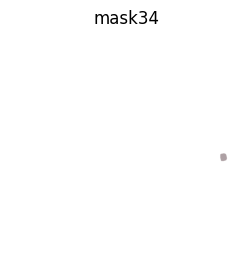

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


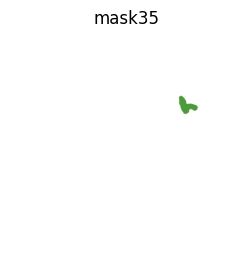

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


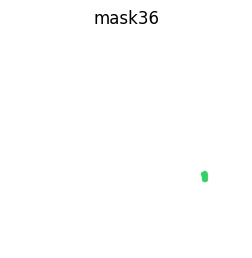

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


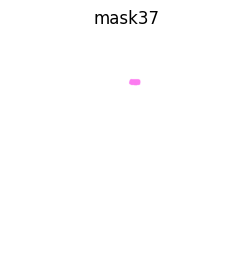

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


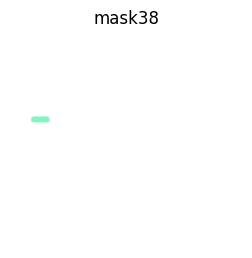

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


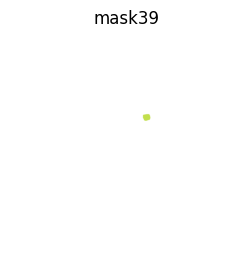

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


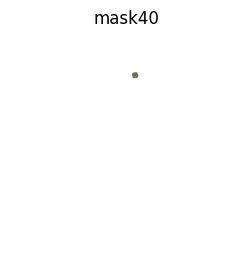

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


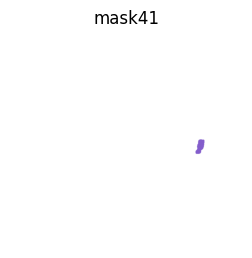

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


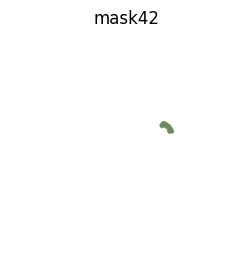

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


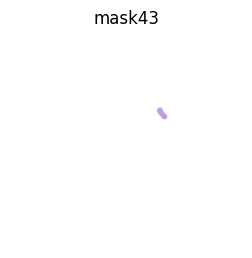

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


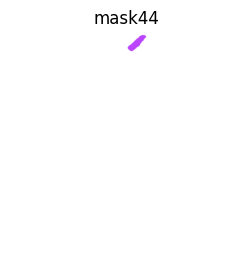

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


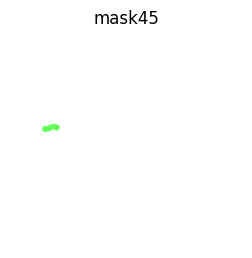

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


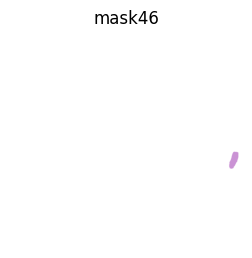

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


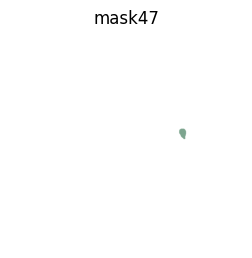

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


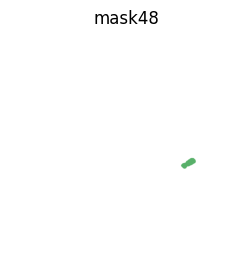

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


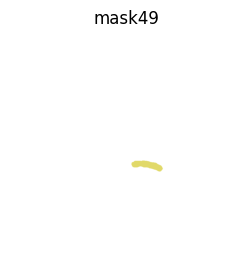

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


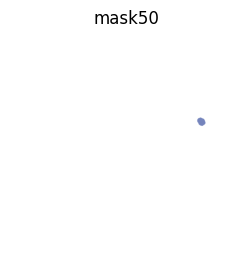

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


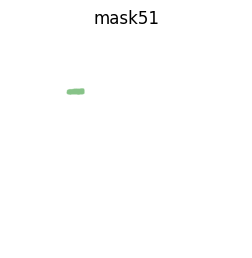

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


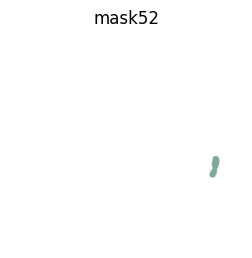

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


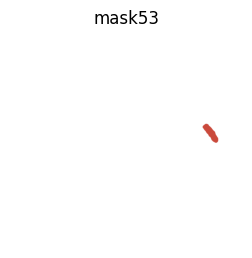

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


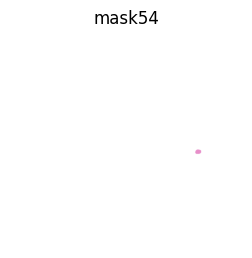

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


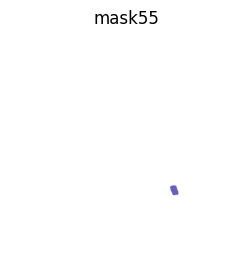

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


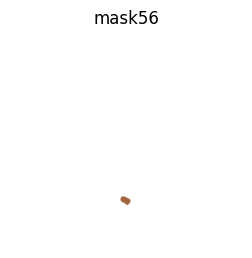

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


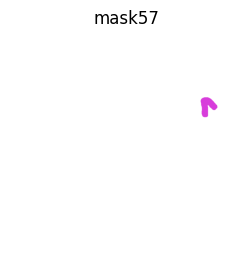

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


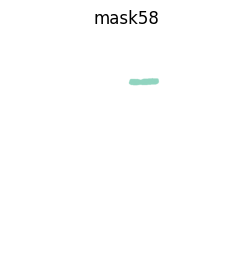

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


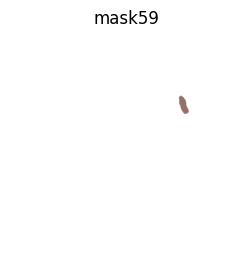

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


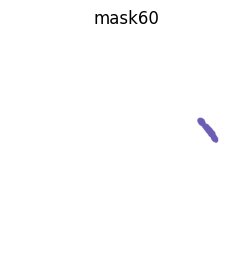

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


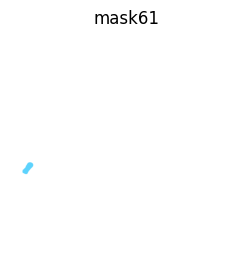

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


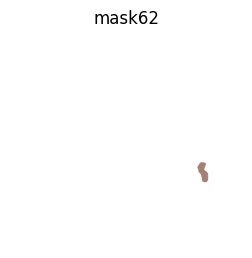

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


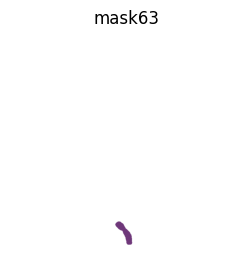

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


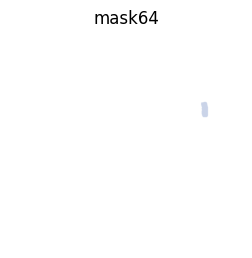

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


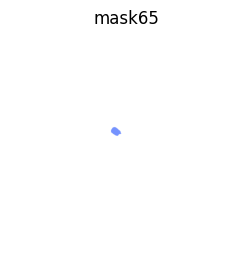

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


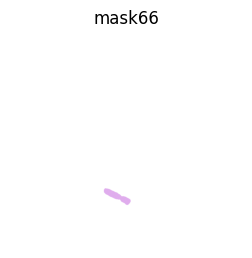

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


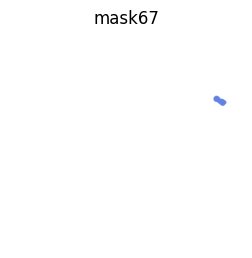

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


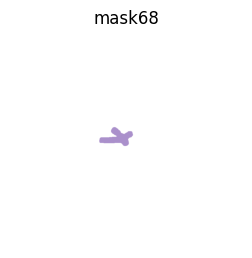

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


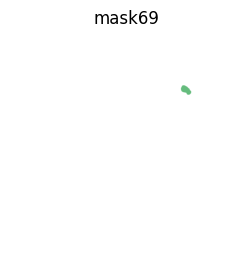

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


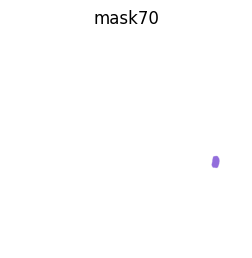

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


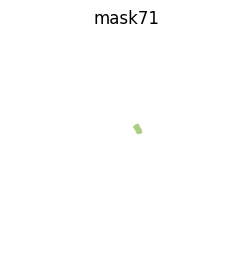

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


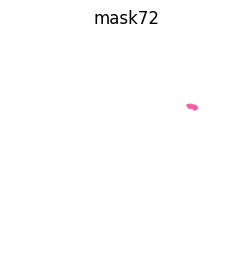

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


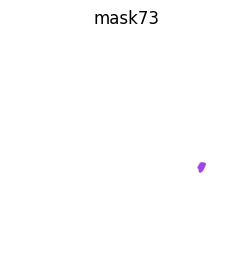

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


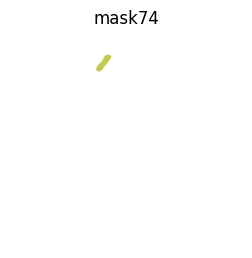

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


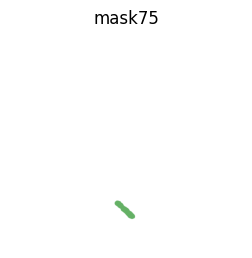

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


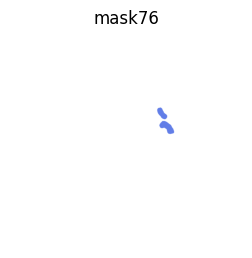

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


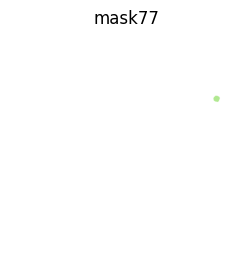

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


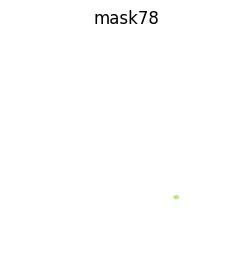

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


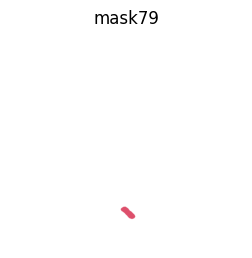

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


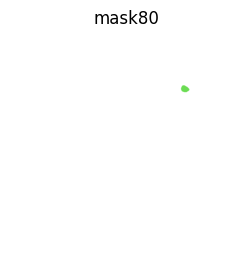

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


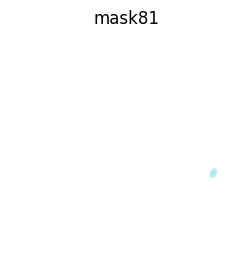

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


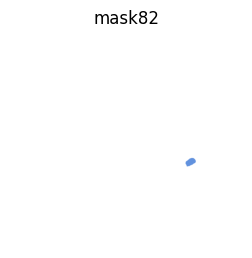

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


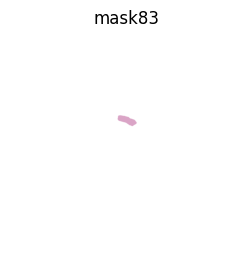

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


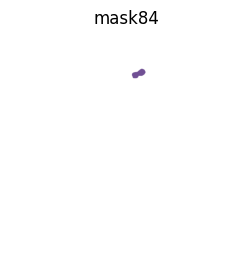

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


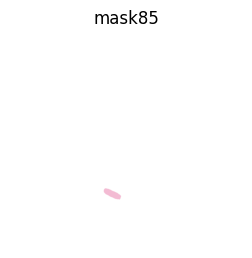

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


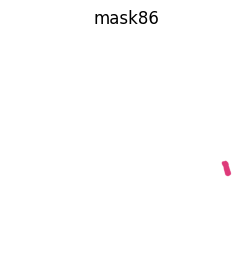

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


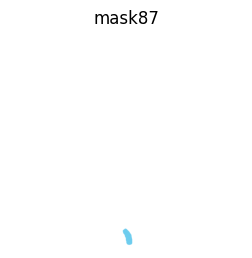

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


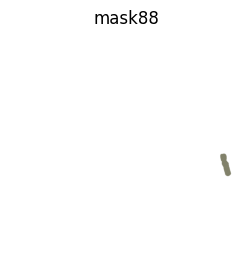

In [8]:
'''
    Abaixo, irei percorrer todas as máscaras geradas pelo algoritmo (acima), e depois, farei o "plotting" de cada uma das máscaras (POTENCIAIS CROMOSSOMOS)

    Como podemos ver no output, o algorítmo encontrou potenciais 113 CROMOSSOMOS (o que está errado).

    Este valor elevado se deve principalmente a imagem de baixa qualidade que usamos, através de uma análise das imagens abaixo (output),
    poderemos ver que o modelo está encontrando diversos "falsos cromossomos" em apenas 1 cromossomo.
'''

for i in range(len(masks1)):
    plt.figure(figsize=(3,3))
    plt.imshow(bgw)
    show_anns([masks1[i]])
    plt.title(f'mask{i}')
    plt.axis('off')  
    plt.show()

# Extração de retângulo da máscara

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask0 bbox: [0, 912, 2, 843]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\000.png


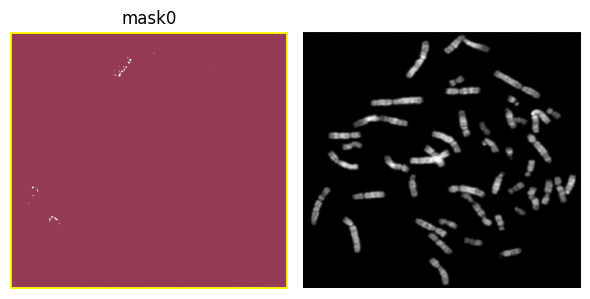

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask1 bbox: [161, 269, 524, 553]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\001.png


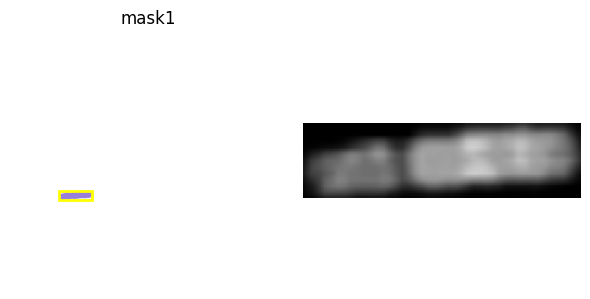

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask2 bbox: [619, 661, 461, 535]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\002.png


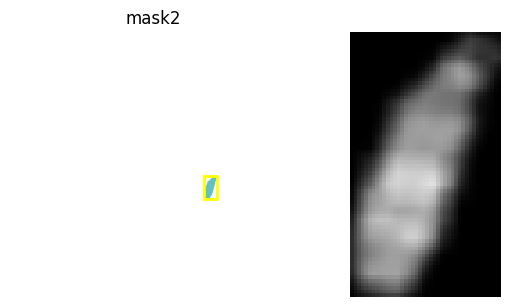

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask3 bbox: [624, 718, 127, 190]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\003.png


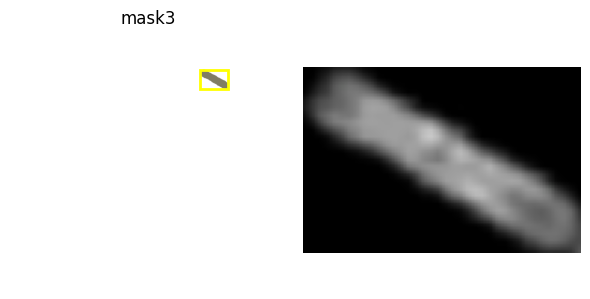

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask4 bbox: [624, 778, 127, 220]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\004.png


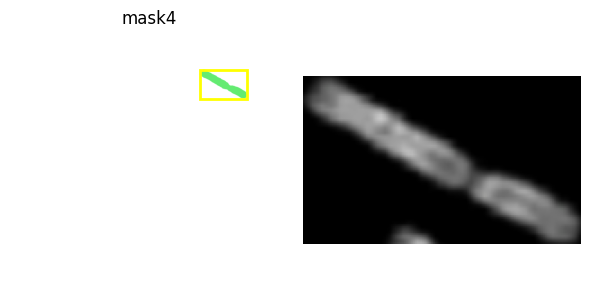

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask5 bbox: [155, 190, 329, 351]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\005.png


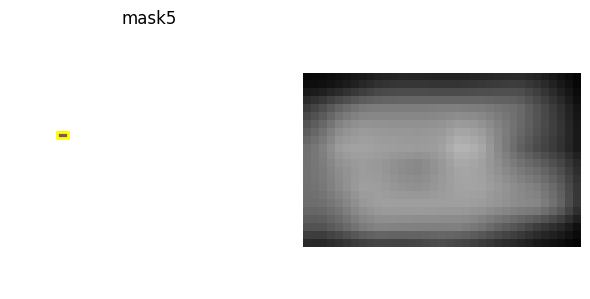

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask6 bbox: [221, 395, 213, 245]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\006.png


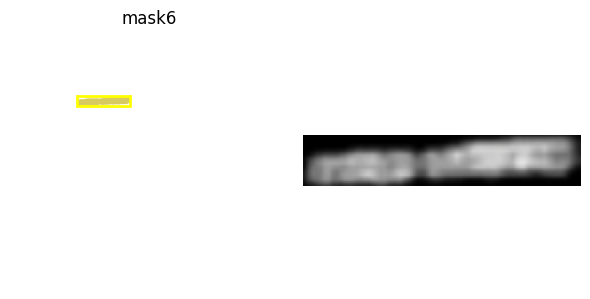

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask7 bbox: [150, 188, 636, 727]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\007.png


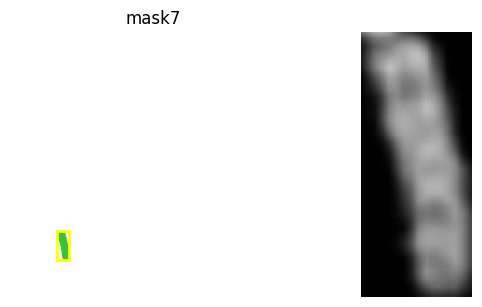

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask8 bbox: [26, 90, 511, 637]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\008.png


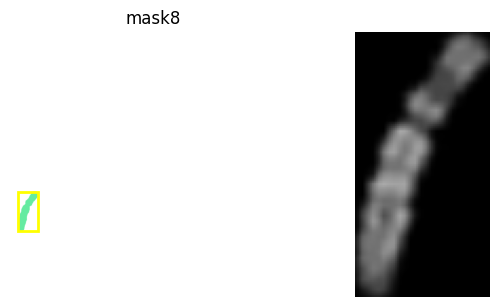

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask9 bbox: [526, 591, 677, 705]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\009.png


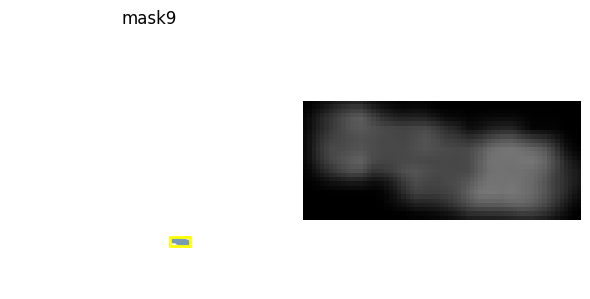

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask10 bbox: [201, 269, 524, 550]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\010.png


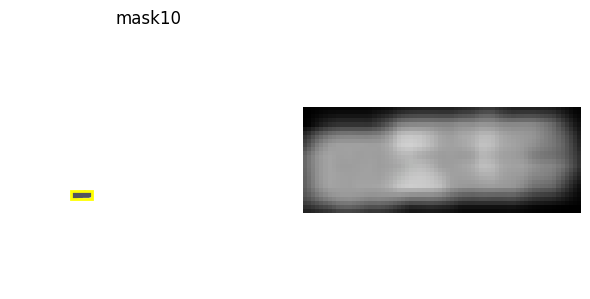

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask11 bbox: [346, 377, 470, 546]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\011.png


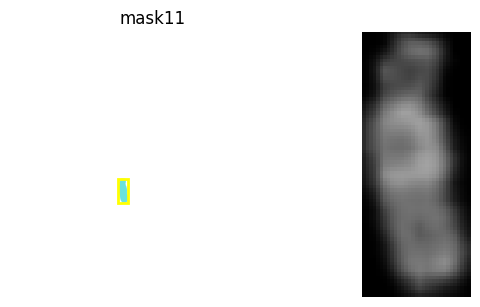

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask12 bbox: [26, 62, 555, 637]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\012.png


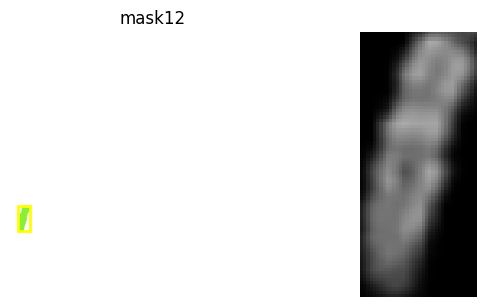

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask13 bbox: [128, 166, 606, 639]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\013.png


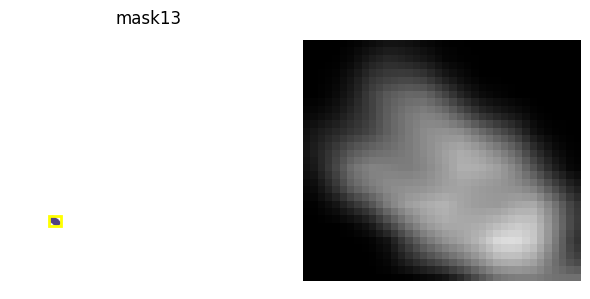

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask14 bbox: [83, 191, 328, 354]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\014.png


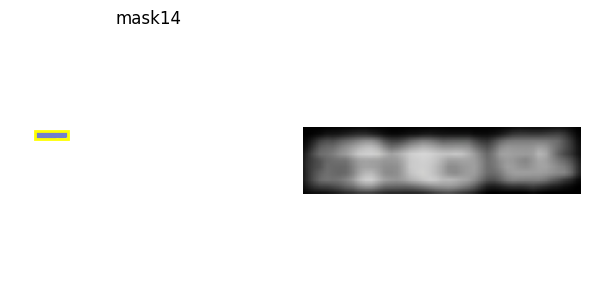

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask15 bbox: [129, 188, 607, 727]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\015.png


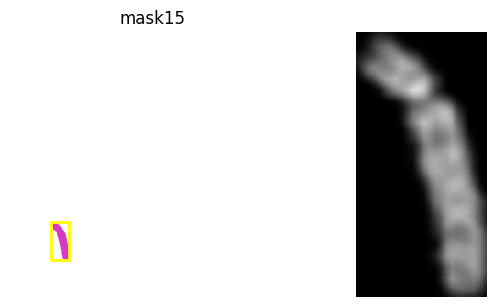

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask16 bbox: [161, 199, 530, 553]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\016.png


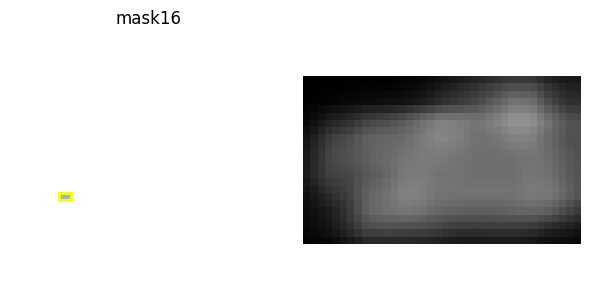

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask17 bbox: [443, 507, 614, 650]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\017.png


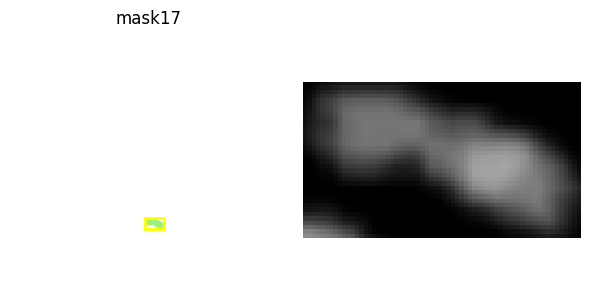

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask18 bbox: [81, 183, 390, 456]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\018.png


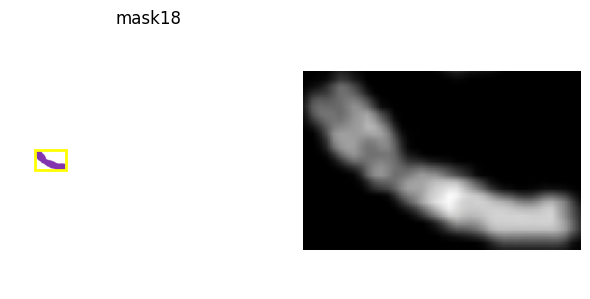

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask19 bbox: [422, 517, 326, 399]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\019.png


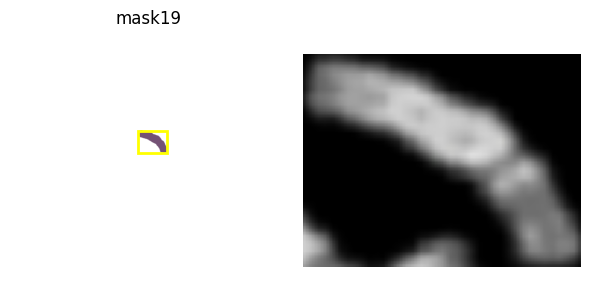

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask20 bbox: [693, 731, 575, 605]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\020.png


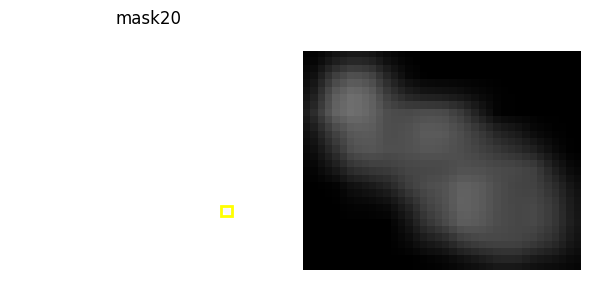

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask21 bbox: [297, 395, 214, 240]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\021.png


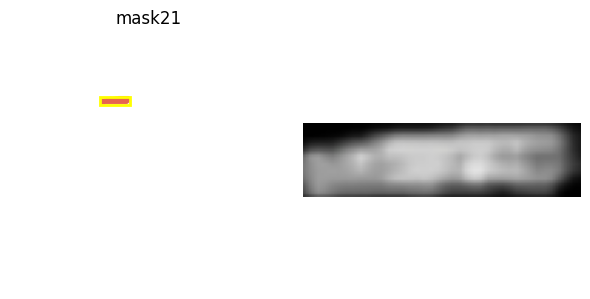

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask22 bbox: [475, 510, 505, 530]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\022.png


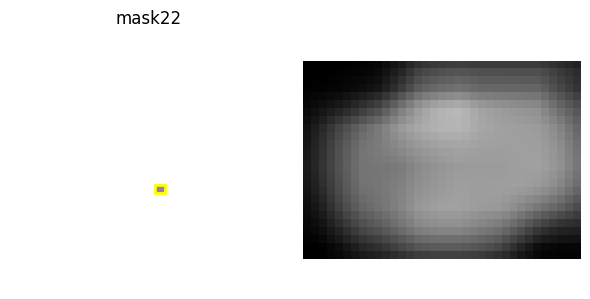

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask23 bbox: [510, 549, 259, 348]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\023.png


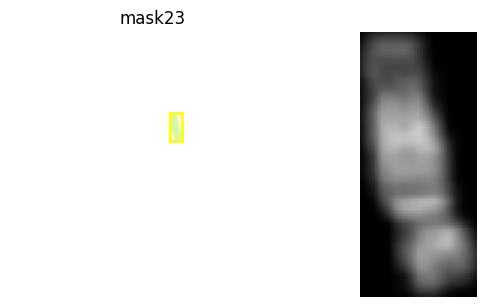

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask24 bbox: [163, 344, 273, 316]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\024.png


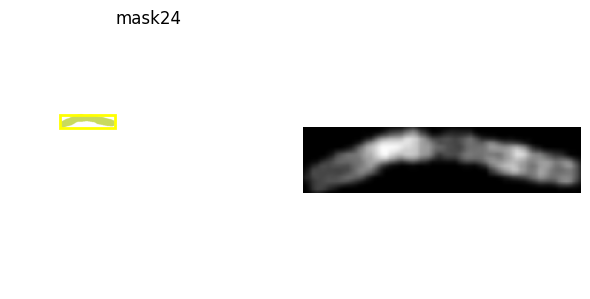

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask25 bbox: [627, 661, 601, 654]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\025.png


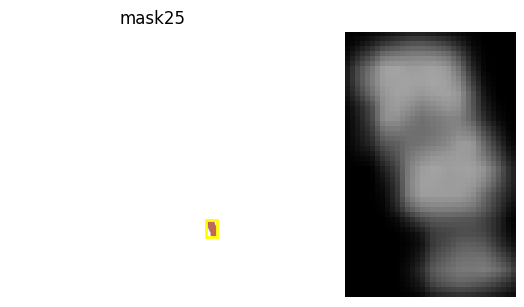

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask26 bbox: [338, 414, 30, 154]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\026.png


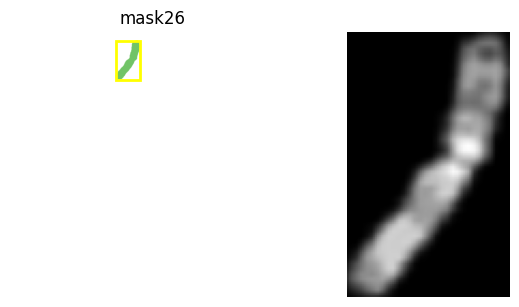

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask27 bbox: [644, 717, 710, 741]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\027.png


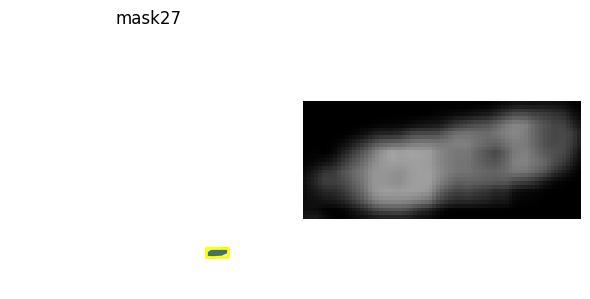

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask28 bbox: [266, 349, 407, 463]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\028.png


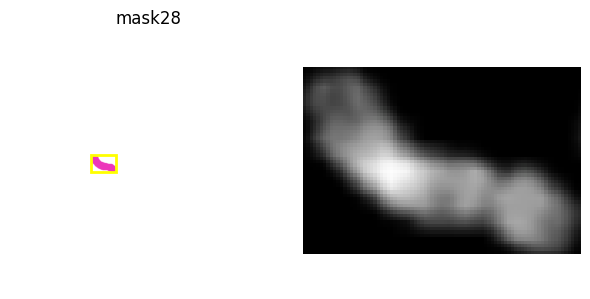

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask29 bbox: [461, 612, 11, 74]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\029.png


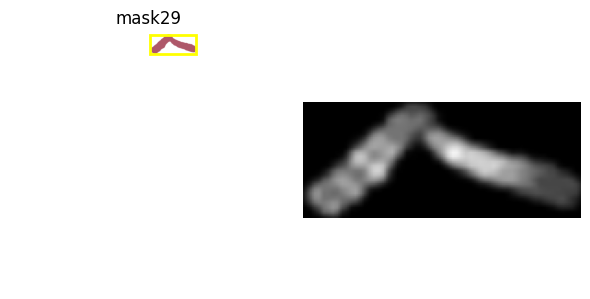

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask30 bbox: [526, 613, 24, 69]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\030.png


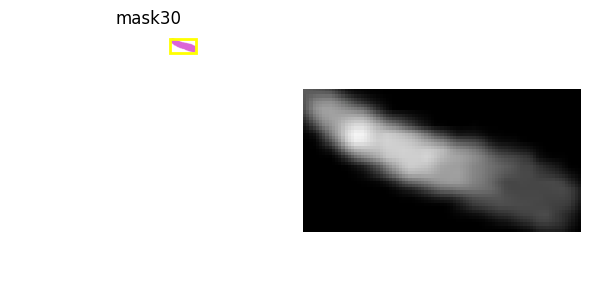

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask31 bbox: [510, 541, 259, 322]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\031.png


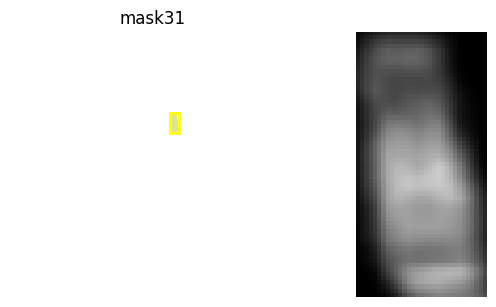

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask32 bbox: [716, 778, 179, 220]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\032.png


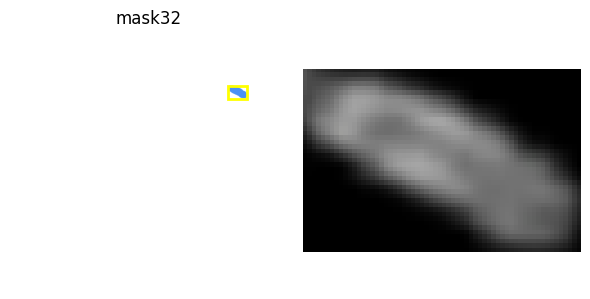

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask33 bbox: [733, 761, 421, 462]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\033.png


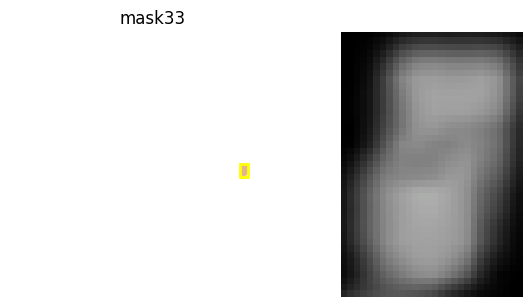

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask34 bbox: [824, 849, 476, 505]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\034.png


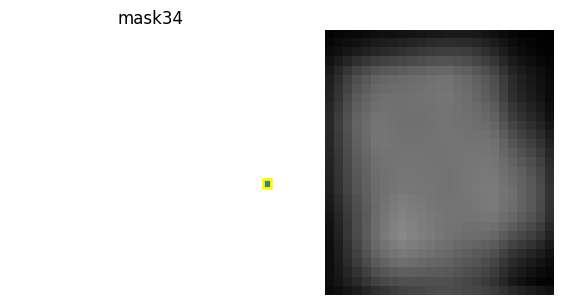

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask35 bbox: [662, 735, 250, 320]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\035.png


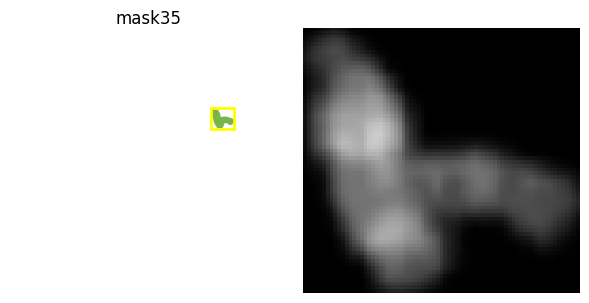

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask36 bbox: [748, 775, 544, 588]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\036.png


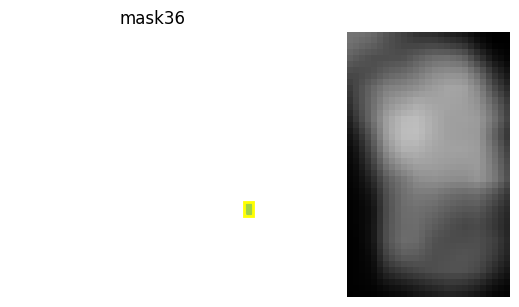

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask37 bbox: [467, 510, 184, 208]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\037.png


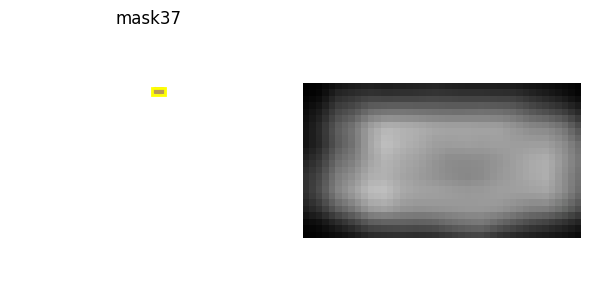

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask38 bbox: [83, 153, 331, 354]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\038.png


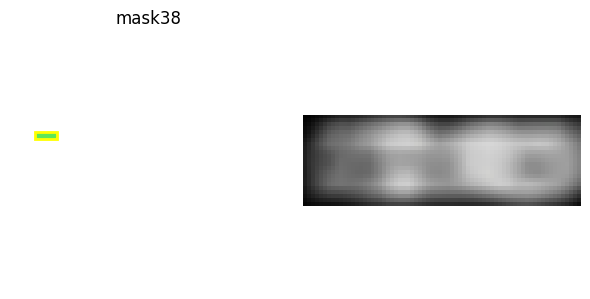

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask39 bbox: [521, 549, 322, 347]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\039.png


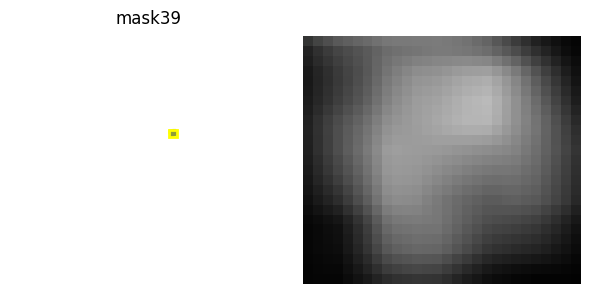

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask40 bbox: [478, 502, 157, 180]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\040.png


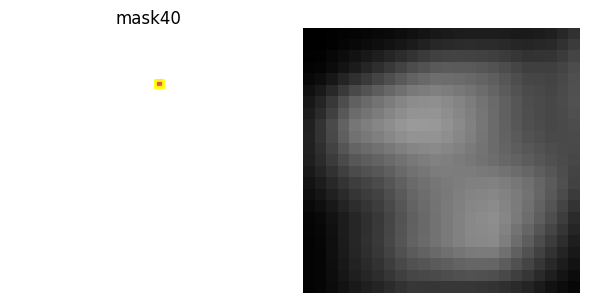

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask41 bbox: [727, 761, 421, 477]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\041.png


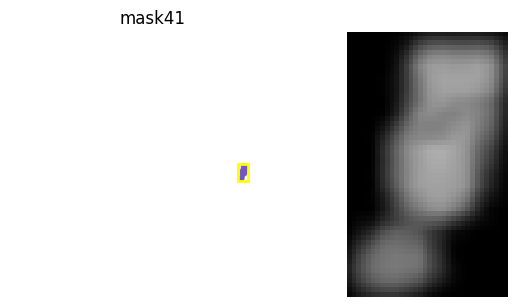

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask42 bbox: [586, 642, 349, 398]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\042.png


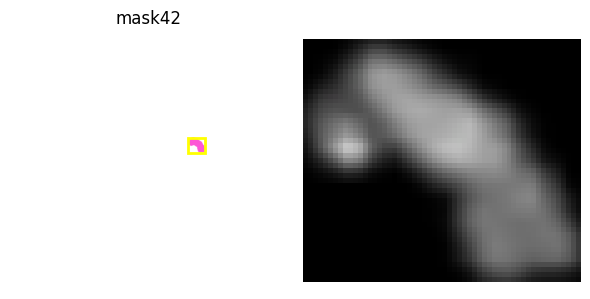

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask43 bbox: [576, 616, 296, 342]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\043.png


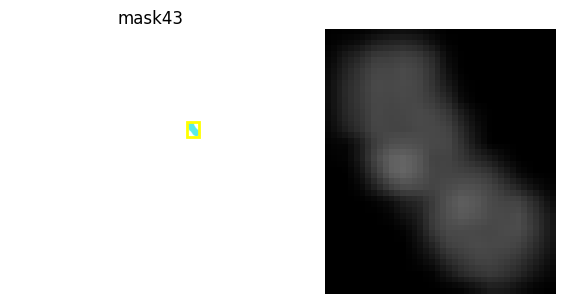

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask44 bbox: [461, 533, 12, 74]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\044.png


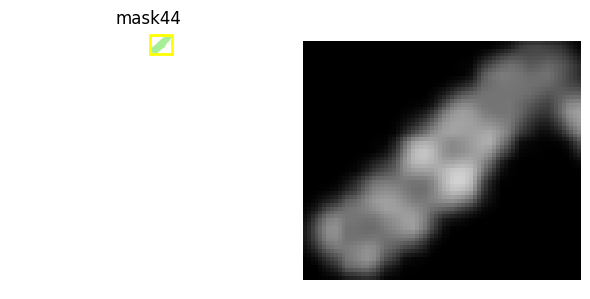

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask45 bbox: [126, 194, 360, 391]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\045.png


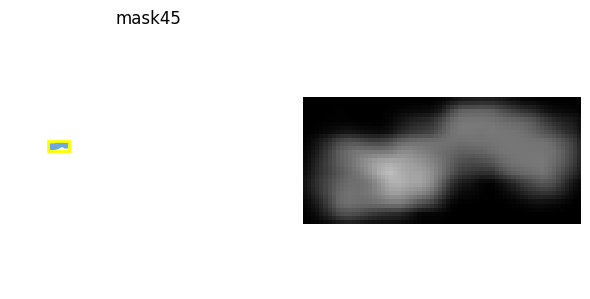

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask46 bbox: [859, 894, 469, 535]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\046.png


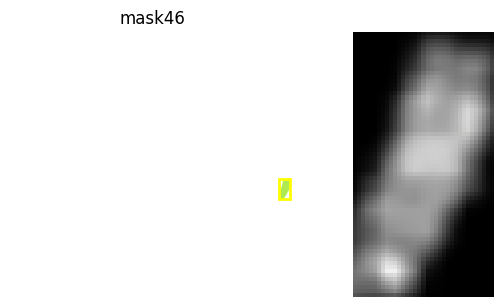

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask47 bbox: [663, 689, 379, 419]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\047.png


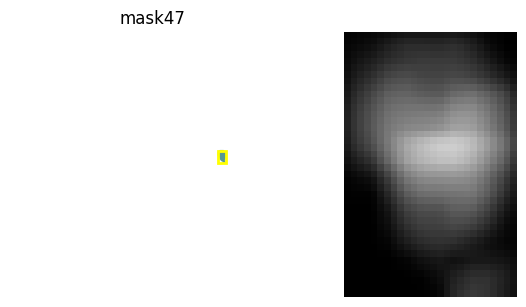

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask48 bbox: [670, 727, 494, 535]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\048.png


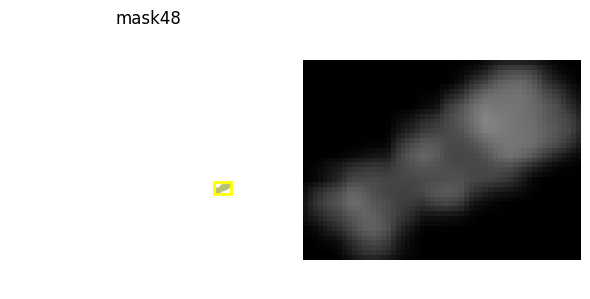

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask49 bbox: [476, 598, 504, 546]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\049.png


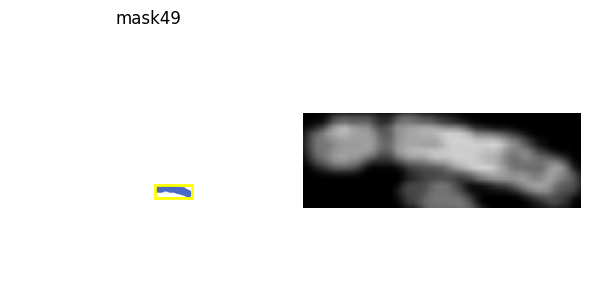

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask50 bbox: [733, 765, 335, 367]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\050.png


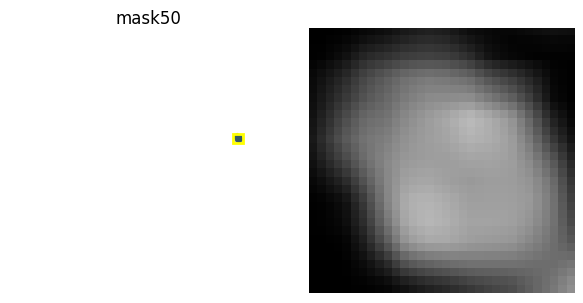

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask51 bbox: [222, 291, 221, 245]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\051.png


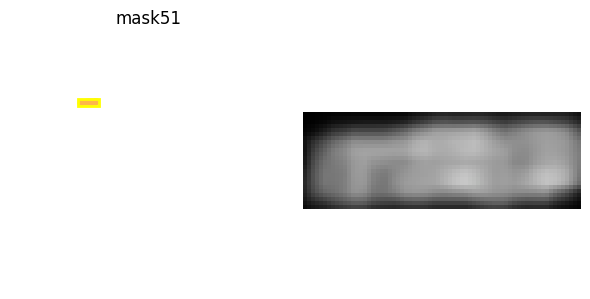

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask52 bbox: [782, 820, 486, 570]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\052.png


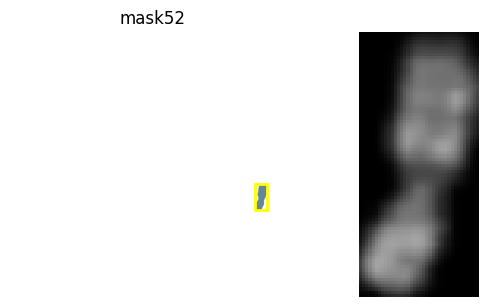

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask53 bbox: [754, 815, 360, 434]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\053.png


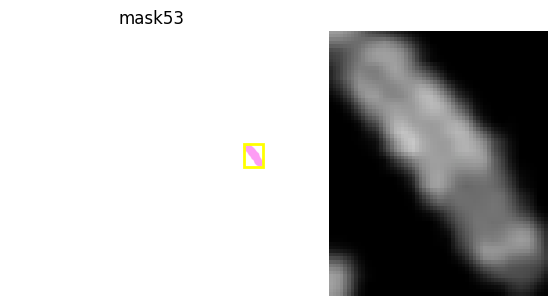

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask54 bbox: [726, 748, 460, 477]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\054.png


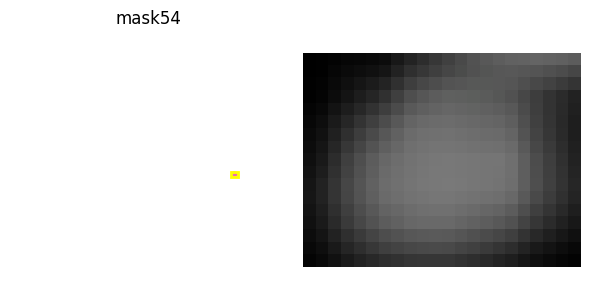

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask55 bbox: [627, 659, 601, 639]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\055.png


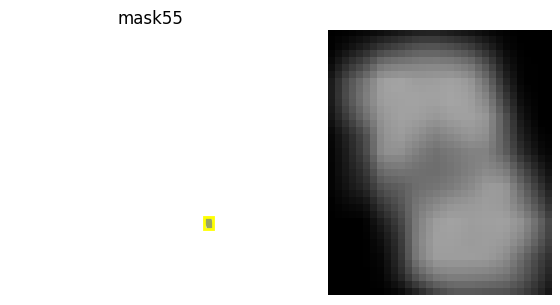

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask56 bbox: [433, 471, 645, 677]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\056.png


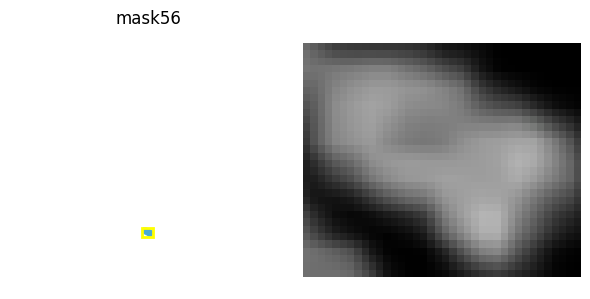

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask57 bbox: [747, 812, 256, 333]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\057.png


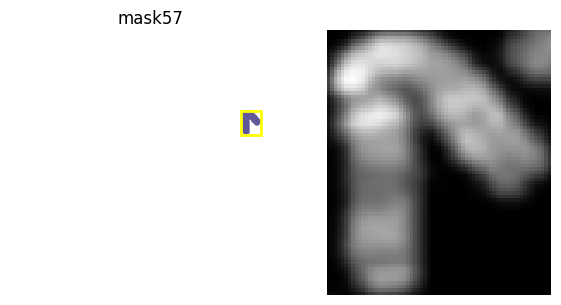

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask58 bbox: [466, 583, 181, 208]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\058.png


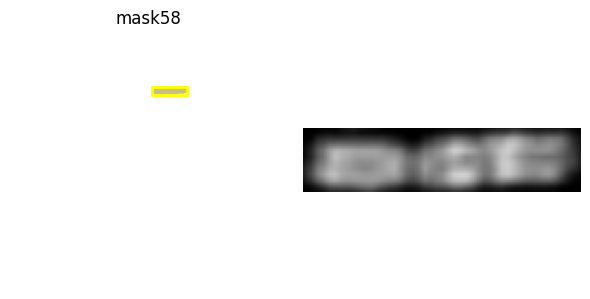

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask59 bbox: [662, 700, 250, 320]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\059.png


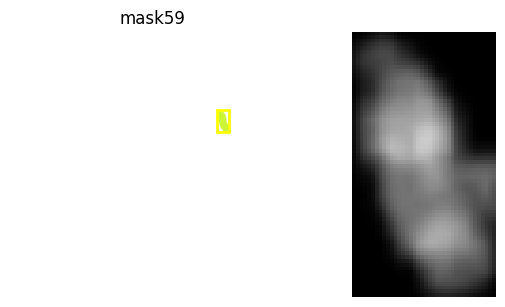

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask60 bbox: [734, 815, 336, 434]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\060.png


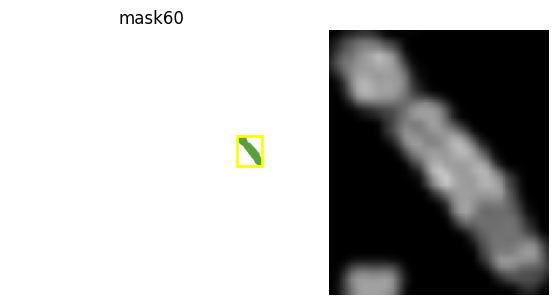

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask61 bbox: [49, 90, 511, 556]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\061.png


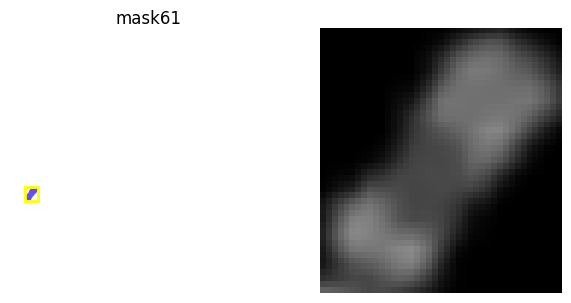

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask62 bbox: [734, 776, 511, 588]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\062.png


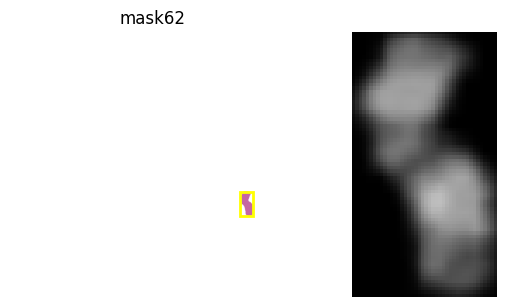

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask63 bbox: [412, 478, 743, 833]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\063.png


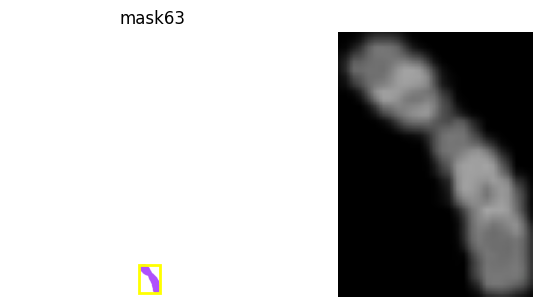

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask64 bbox: [749, 775, 274, 333]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\064.png


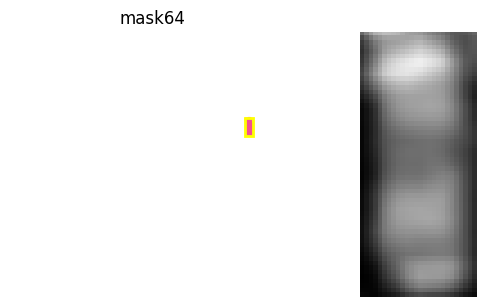

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask65 bbox: [396, 435, 373, 406]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\065.png


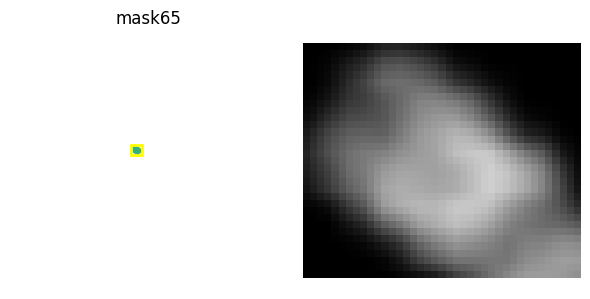

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask66 bbox: [368, 472, 613, 677]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\066.png


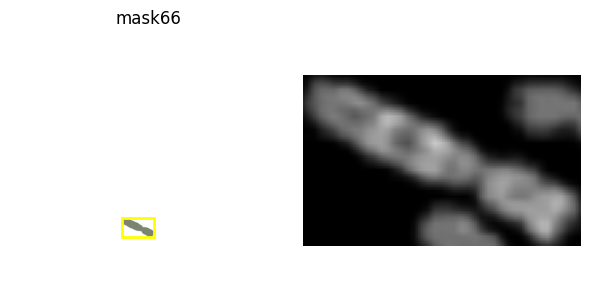

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask67 bbox: [797, 847, 250, 289]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\067.png


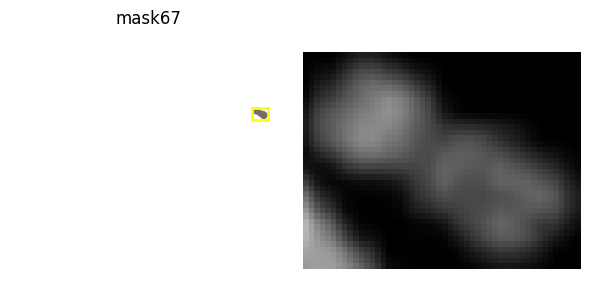

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask68 bbox: [350, 481, 373, 446]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\068.png


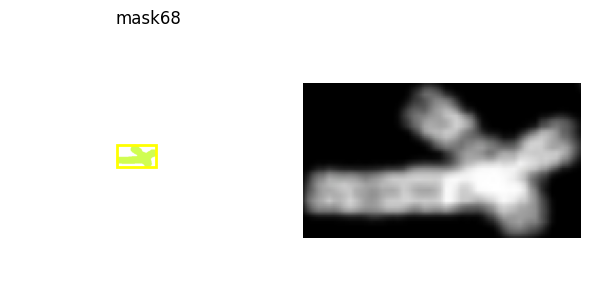

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask69 bbox: [670, 709, 209, 245]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\069.png


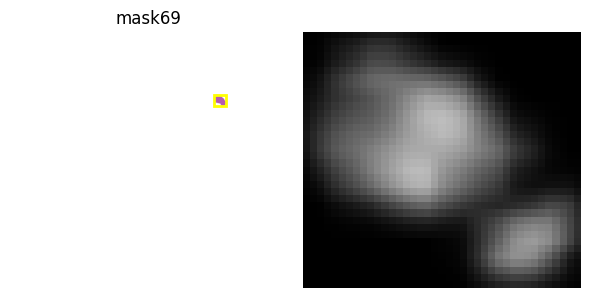

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask70 bbox: [790, 820, 486, 532]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\070.png


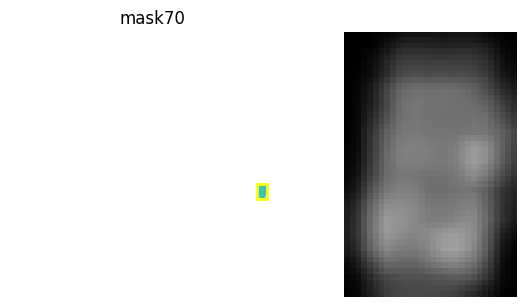

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask71 bbox: [482, 517, 359, 399]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\071.png


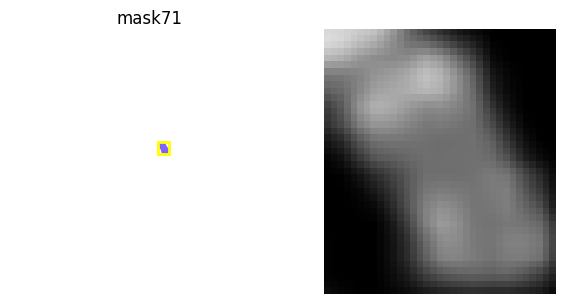

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask72 bbox: [691, 736, 281, 308]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\072.png


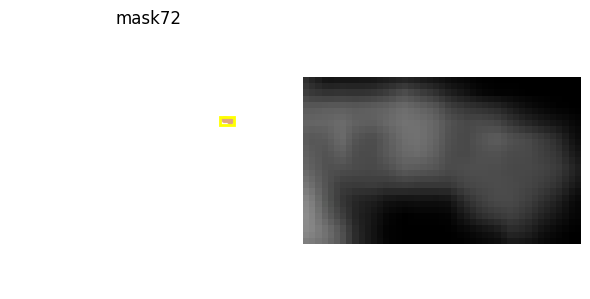

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask73 bbox: [734, 768, 511, 551]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\073.png


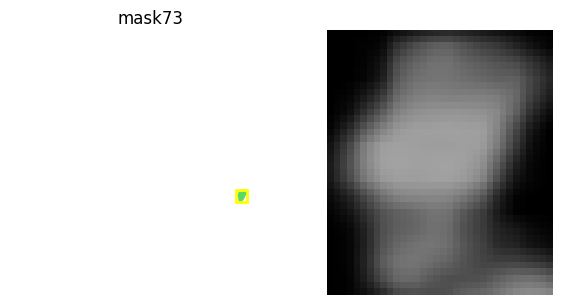

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask74 bbox: [338, 397, 88, 154]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\074.png


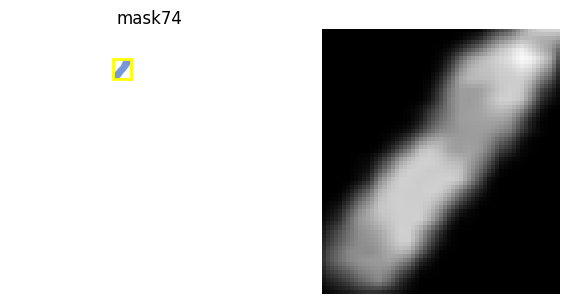

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask75 bbox: [410, 489, 661, 732]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\075.png


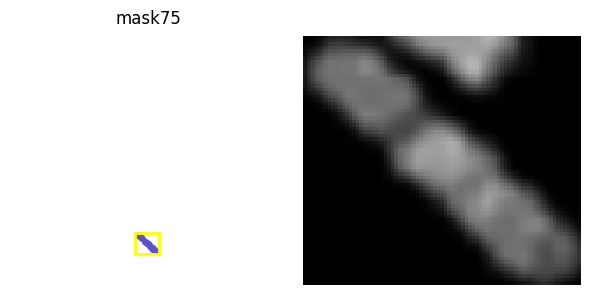

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask76 bbox: [577, 642, 296, 399]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\076.png


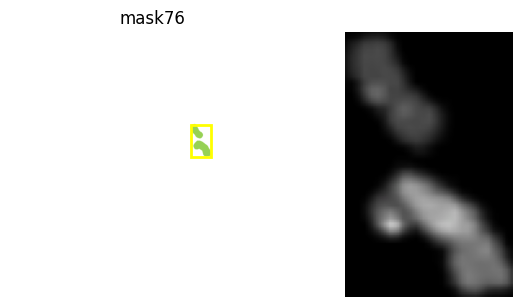

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask77 bbox: [797, 821, 250, 273]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\077.png


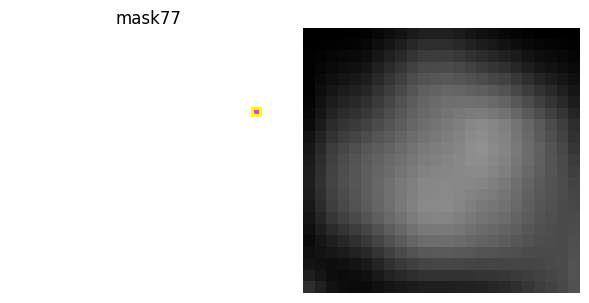

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask78 bbox: [640, 661, 640, 655]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\078.png


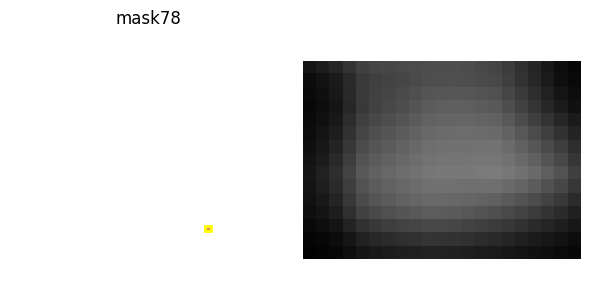

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask79 bbox: [434, 490, 685, 732]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\079.png


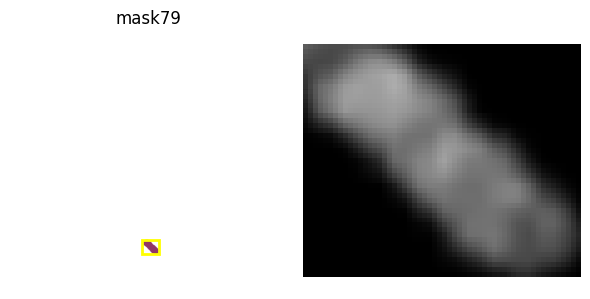

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask80 bbox: [670, 702, 209, 235]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\080.png


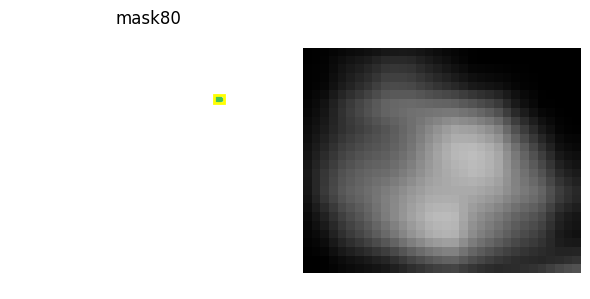

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask81 bbox: [781, 810, 534, 570]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\081.png


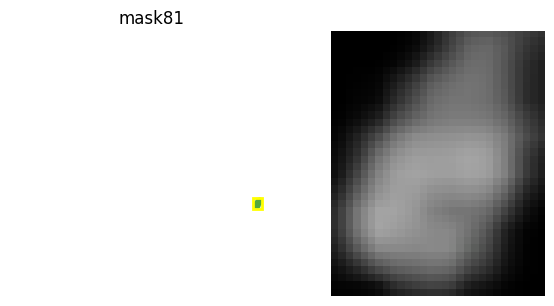

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask82 bbox: [688, 727, 494, 526]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\082.png


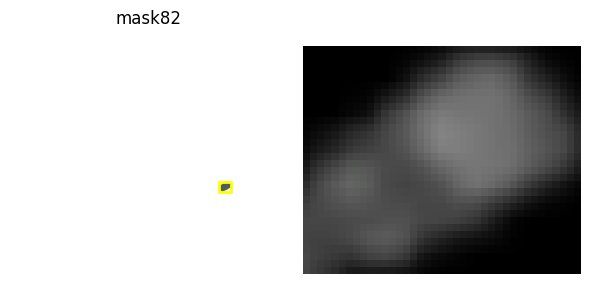

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask83 bbox: [422, 496, 326, 368]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\083.png


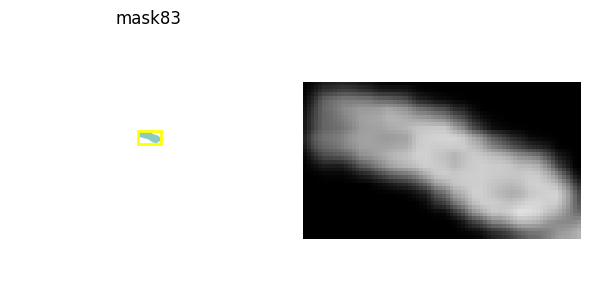

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask84 bbox: [478, 530, 144, 181]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\084.png


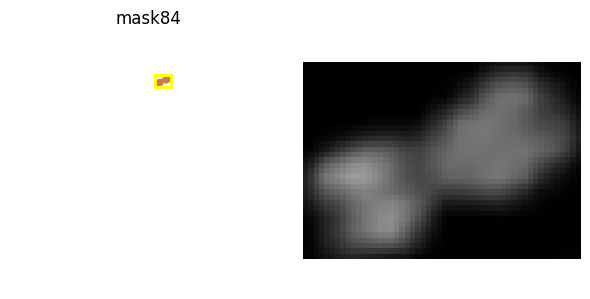

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask85 bbox: [367, 434, 613, 656]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\085.png


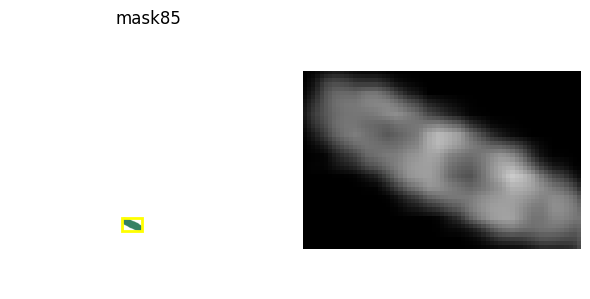

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask86 bbox: [830, 865, 505, 564]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\086.png


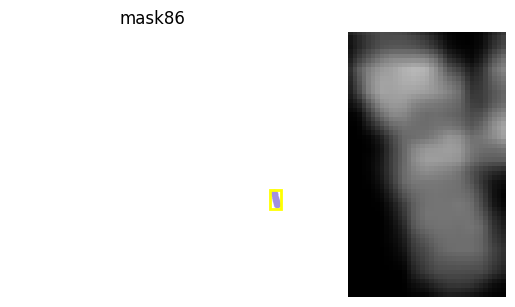

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask87 bbox: [442, 478, 771, 834]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\087.png


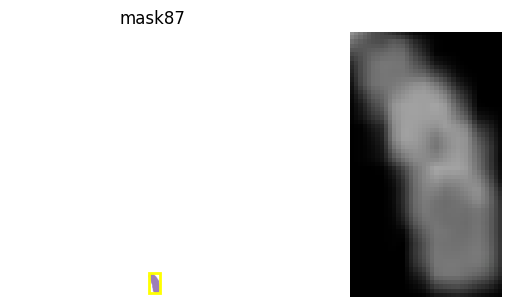

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask88 bbox: [824, 865, 477, 564]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\FundoPreto\088.png


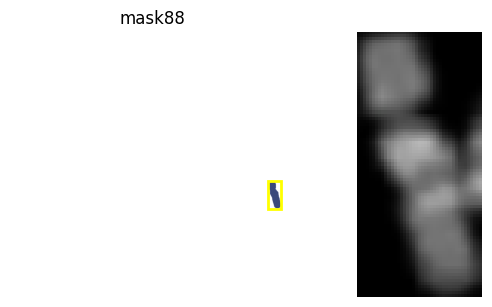

In [9]:
'''
    Com as máscaras obtidas anteriormente, é possível plottarmos retângulos de identificação em cada cromossomo identificado pelo modelo.
    Após realizarmos os "recortes", as imagens serão salvas na pasta "/recortes/"
    Como podemos ver a seguir:
'''

# Criação da pasta recortes
os.makedirs('recortes/FundoPreto', exist_ok=True)

# Itera pelas máscaras
for i in range(len(masks1)):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    ax[0].imshow(bgw)
    masksi = masks1[i]
    xc, yc, w, h = masksi['bbox']
    x0, y0, x1, y1 = int(xc), int(yc), int(xc + w), int(yc + h)

    print(f'mask{i} bbox: {[x0, x1, y0, y1]}')

    # Recorte da imagem original
    boximage = image[y0:y1, x0:x1, :]

    # Caminho absoluto para salvar
    save_path = os.path.abspath(os.path.join('recortes/FundoPreto', f'{str(i).zfill(3)}.png'))
    print(f"Imagem salva em em: {save_path}")

    # Salva o recorte
    cv2.imwrite(save_path, cv2.cvtColor(boximage, cv2.COLOR_RGB2BGR))

    # Exibição
    rect = patches.Rectangle((xc, yc), w, h, linewidth=2, edgecolor='yellow', fill=False)
    show_anns([masksi], ax[0])
    ax[0].add_patch(rect)
    ax[1].imshow(boximage)
    ax[0].set_title(f'mask{i}')
    ax[0].axis('off')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
'''
    Conclui-se que, utilizando o modelo "vit-b" (Vision Transformer BASE), conseguimos obter resultados melhores e mais acertivos.
    Também observa-se um tempo de resposta MUITO MENOR.

    Antes -> Identificação de 113 cromossomos em aprox. 8 minutos.                      (tempo de identificação + plottagem gráfica)
    Depois -> Identificação de 88 cromossomos em aprox. 2 minutos e 34 segundos.        (tempo de identificação + plottagem gráfica)
'''

'\n    Conclui-se que, utilizando o modelo "vit-b" (Vision Transformer BASE), conseguimos obter resultados melhores e mais acertivos.\n    Também observa-se um tempo de resposta MUITO MENOR.\n\n    Antes -> Identificação de 113 cromossomos em aprox. 4 minutos            (tempo de identificação + plottagem gráfica)\n    Depois -> Identificação de 50 cromossomos em aprox. 47 segundos.        (tempo de identificação + plottagem gráfica)\n'